# Convolutional Neural Networks - Report
---
The CNN model consists of five convolutional layers followed by max pooling, ReLU activation, and fully connected layers. The model is structured as follows:

| Layer Type  | Details |
|-------------|---------|
| **Input**   | 3 x 32 x 32 RGB image |
| **Conv1**   | 16 filters, 3x3 kernel, ReLU |
| **MaxPool1**| 2x2 pooling |
| **Conv2**   | 32 filters, 3x3 kernel, ReLU |
| **MaxPool2**| 2x2 pooling |
| **Conv3**   | 64 filters, 3x3 kernel, ReLU |
| **MaxPool3**| 2x2 pooling |
| **Conv4**   | 128 filters, 3x3 kernel, ReLU |
| **MaxPool4**| 2x2 pooling |
| **Conv5**   | 256 filters, 3x3 kernel, ReLU |
| **MaxPool5**| 2x2 pooling |
| **Flatten** | Converts to vector format |
| **FC1**     | Fully connected layer (500 neurons) |
| **Dropout** | 25% dropout |
| **FC2 (Output)** | 10 neurons (one per class) |

The CNN architecture was designed to extract hierarchical features from images, progressively reducing spatial dimensions while increasing feature depth.


<img src="cnn_architecture.png" width="500">

Test Accuracy (Overall): 77% (7741/10000)


### Optional: Use [CUDA](http://pytorch.org/docs/stable/cuda.html) if Available

Since these are color (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, but they utilize GPU's for effcient parallel computation.

In [ ]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)
---
Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170M/170M [00:03<00:00, 49.0MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Visualize a Batch of Training Data

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

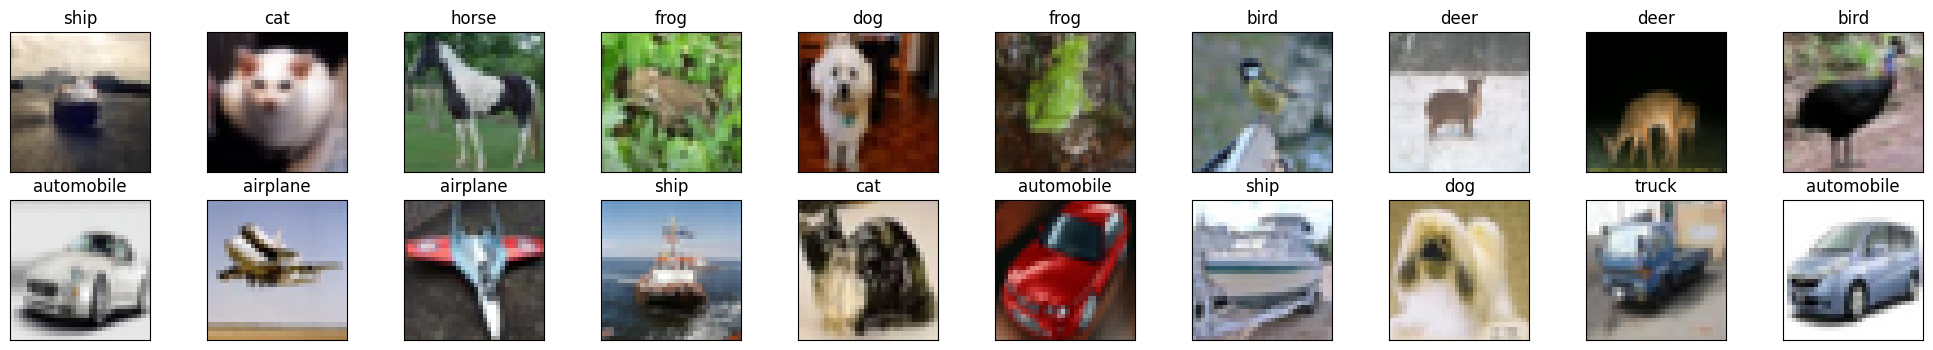

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
#images, labels = dataiter.next() #python, torchvision version match issue
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

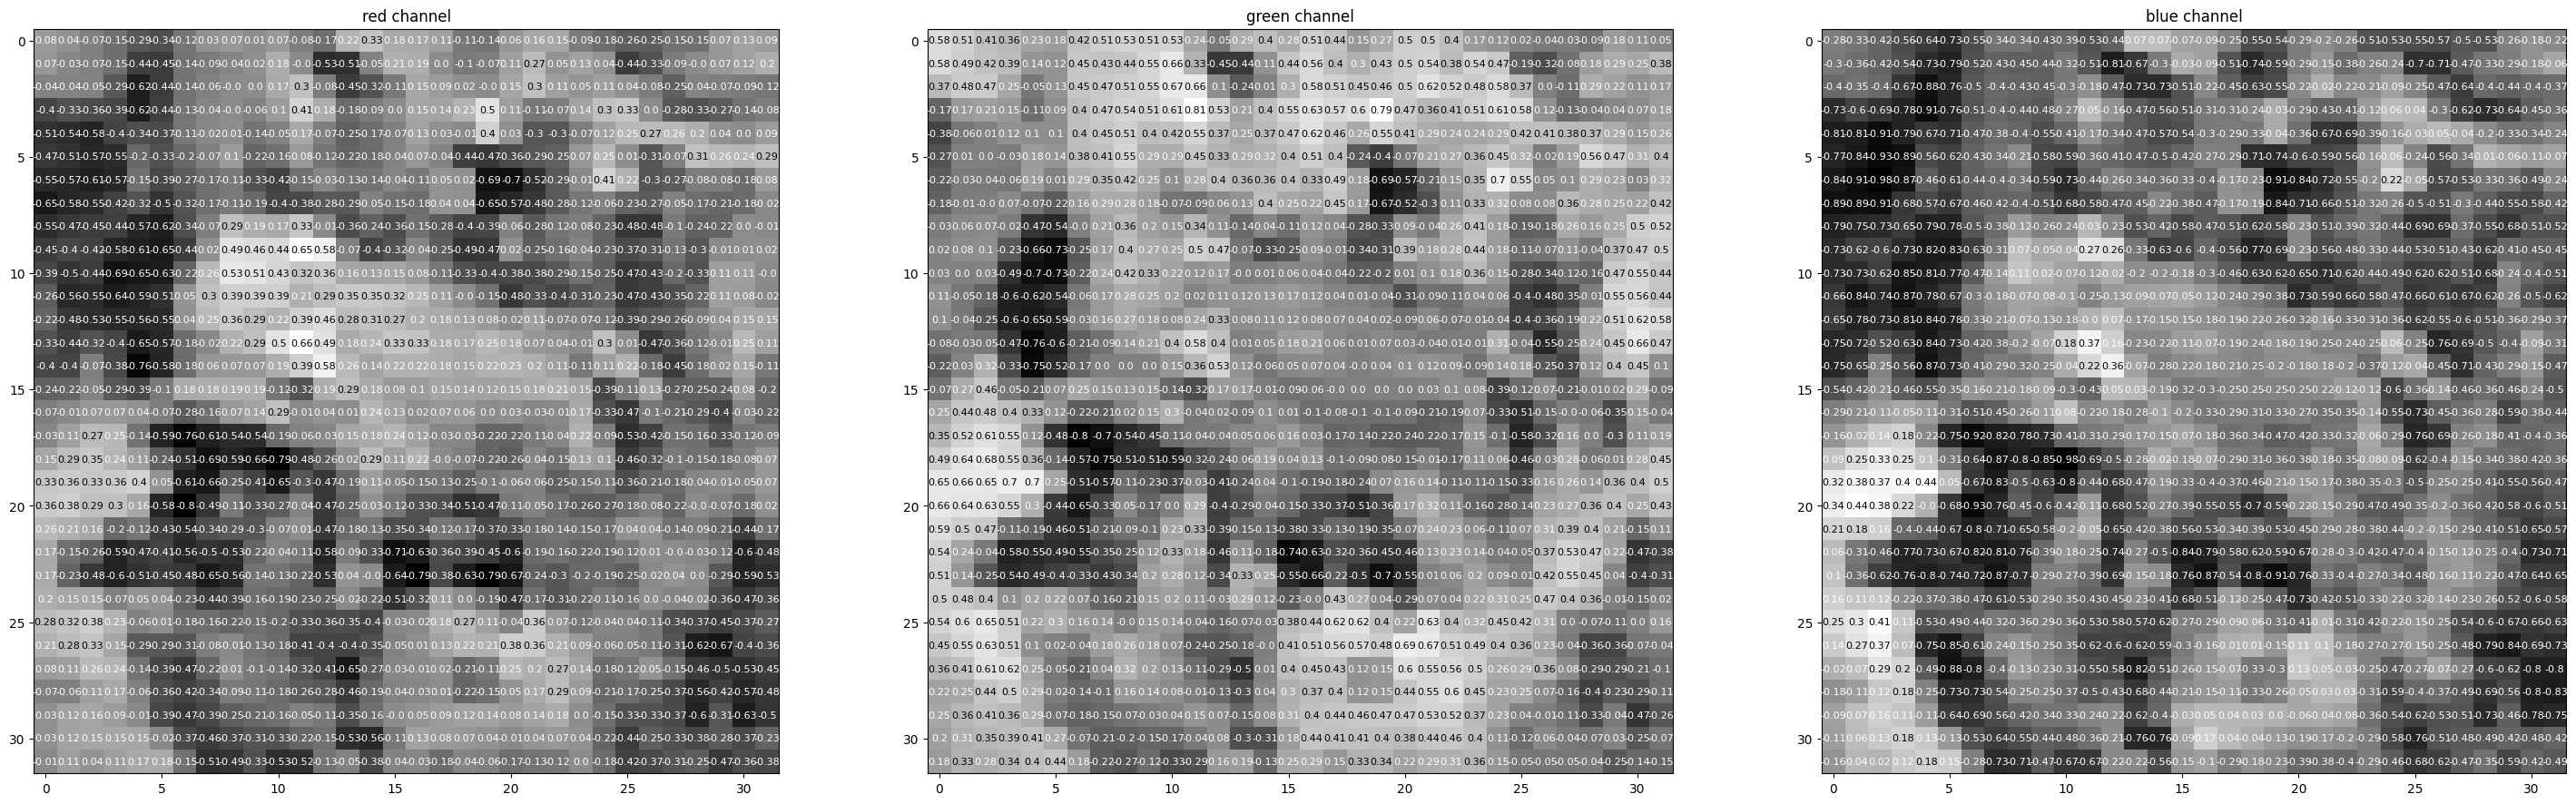

In [ ]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## Network [Architecture](http://pytorch.org/docs/stable/nn.html)
---
| Layer Type  | Details |
|-------------|---------|
| **Input**   | 3 x 32 x 32 RGB image |
| **Conv1**   | 16 filters, 3x3 kernel, ReLU |
| **MaxPool1**| 2x2 pooling |
| **Conv2**   | 32 filters, 3x3 kernel, ReLU |
| **MaxPool2**| 2x2 pooling |
| **Conv3**   | 64 filters, 3x3 kernel, ReLU |
| **MaxPool3**| 2x2 pooling |
| **Conv4**   | 128 filters, 3x3 kernel, ReLU |
| **MaxPool4**| 2x2 pooling |
| **Conv5**   | 256 filters, 3x3 kernel, ReLU |
| **MaxPool5**| 2x2 pooling |
| **Flatten** | Converts to vector format |
| **FC1**     | Fully connected layer (500 neurons) |
| **Dropout** | 25% dropout |
| **FC2 (Output)** | 10 neurons (one per class) |



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=51

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)
---
Adam optimizer with learning rate `0.001`

In [ ]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

print("Optimizers defined: SGD and Adam")

Optimizers defined: SGD and Adam


## Train the Network
---
- **Optimizer:** Adam optimizer with learning rate `0.001`
- **Loss Function:** Cross-Entropy Loss
- **Batch Size:** 20
- **Epochs:** 30
- **Hardware:** CUDA-enabled GPU (if available)

In [ ]:
# number of epochs to train the model, you decide the number
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_adam.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer_adam.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler )
    valid_loss = valid_loss/len(valid_loader.sampler)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_trained.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.779589 	Validation Loss: 1.561312
Validation loss decreased (inf --> 1.561312).  Saving model ...
Epoch: 2 	Training Loss: 1.458182 	Validation Loss: 1.352581
Validation loss decreased (1.561312 --> 1.352581).  Saving model ...
Epoch: 3 	Training Loss: 1.290130 	Validation Loss: 1.245579
Validation loss decreased (1.352581 --> 1.245579).  Saving model ...
Epoch: 4 	Training Loss: 1.183430 	Validation Loss: 1.171246
Validation loss decreased (1.245579 --> 1.171246).  Saving model ...
Epoch: 5 	Training Loss: 1.096086 	Validation Loss: 1.106244
Validation loss decreased (1.171246 --> 1.106244).  Saving model ...
Epoch: 6 	Training Loss: 1.016939 	Validation Loss: 1.079130
Validation loss decreased (1.106244 --> 1.079130).  Saving model ...
Epoch: 7 	Training Loss: 0.953545 	Validation Loss: 1.055014
Validation loss decreased (1.079130 --> 1.055014).  Saving model ...
Epoch: 8 	Training Loss: 0.904944 	Validation Loss: 1.036048
Validation loss decreased (1.05501

###  Load the Model with the Lowest Validation Loss

In [ ]:
model.load_state_dict(torch.load('model_trained.pt'))

<ipython-input-13-1ebf1a10fb42>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_trained.pt'))


<All keys matched successfully>

## Test the Trained Network
---

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.037960

Test Accuracy of airplane: 79% (792/1000)
Test Accuracy of automobile: 93% (939/1000)
Test Accuracy of  bird: 69% (697/1000)
Test Accuracy of   cat: 66% (669/1000)
Test Accuracy of  deer: 68% (688/1000)
Test Accuracy of   dog: 53% (533/1000)
Test Accuracy of  frog: 84% (846/1000)
Test Accuracy of horse: 86% (868/1000)
Test Accuracy of  ship: 87% (877/1000)
Test Accuracy of truck: 83% (832/1000)

Test Accuracy (Overall): 77% (7741/10000)


### Visualize Sample Test Results

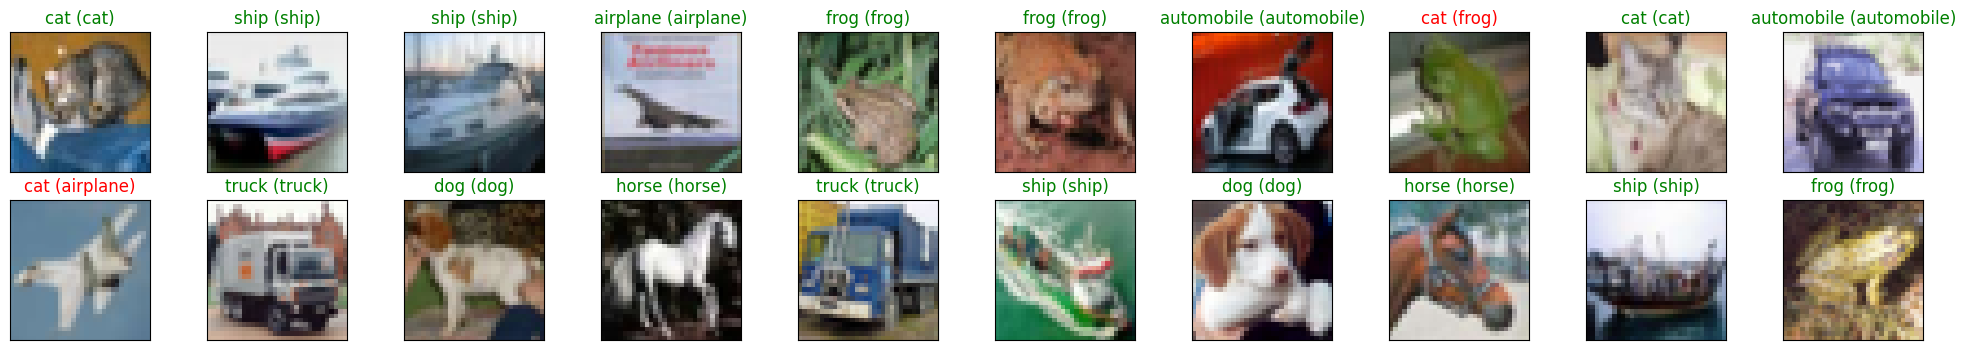

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [ ]:
!pip install torchviz

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from torchviz import make_dot

sample_input = torch.randn(1, 3, 32, 32).to(device)
output = model(sample_input)

# Generate visualization
dot = make_dot(output, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('cnn_architecture1')

'cnn_architecture1.png'